In [1]:
import pandas as pd
from pathlib import Path
dpath = Path("data/YearPredictionMSD.txt")

In [2]:
records = []
with dpath.open("r") as infile:
    for line in infile.readlines():
        line_split = line.replace("\n", "").split(",")
        year = int(line_split[0])
        inputs = [*map(lambda x: float(x), line_split[1:])]
        records.append([year] + inputs)

In [3]:
df = pd.DataFrame(records)

In [4]:
df.columns = ["year"] + [f"feature_{i}" for i in range(1, df.shape[-1])]

In [5]:
df.head()

,year,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [6]:
df.shape

(515345, 91)

In [57]:
# As per instructions https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD
train_samples = 463715
train = df.iloc[:train_samples,:]
test = df.iloc[train_samples:, :]

train_y = train.year.values
test_y = test.year.values
train_x = train.iloc[:, 1:].values
test_x = test.iloc[:, 1:].values

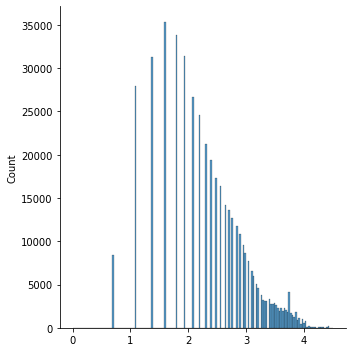

In [46]:
# Transform outcome variable (left-skewed)
import matplotlib.pyplot as plt
import seaborn as sns

max_out_train = np.max(train_y)
train_y_reflected = np.log(1 + max_out_train - train_y)
test_y_reflected = np.log(1 + max_out_train - test_y)

sns.displot(train_y_reflected)
plt.show()

In [47]:
from piven.regressors import build_keras_piven
from piven.loss import piven_loss
from piven.metrics import mpiw, picp
from piven.transformers import PivenTransformedTargetRegressor
from piven.wrappers import PivenModelWrapper
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Make build function for the model wrapper
def piven_model(input_dim, dense_units, dropout_rate):
    model = build_keras_piven(input_dim=input_dim,
                             dense_units=dense_units,
                             dropout_rate=dropout_rate,
                             activation="relu",
                             bias_init_low=-3,
                             bias_init_high=3)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  loss=piven_loss(15.0, 160.0, 0.05),
                  metrics=[picp, mpiw])
    return model

In [48]:
# Set up the model using the MLP that comes with piven.py
model = PivenModelWrapper(build_fn=piven_model, 
                          input_dim=train_x.shape[-1], 
                          dense_units=(64,32), 
                          dropout_rate=(0.0,0.0))

In [49]:
# Put model in pipeline
pipeline = Pipeline([
    ("preprocess", StandardScaler()),
    ("model", model)
])

In [50]:
# Add to transformed target regressor
model_ttr = PivenTransformedTargetRegressor(
    regressor=pipeline,
    transformer=StandardScaler()
)

In [51]:
# Fit
import numpy as np
h = model_ttr.fit(train_x, train_y_reflected, model__epochs=15, model__validation_split=0.2, model__batch_size=64)

Epoch 1/15
5797/5797 [==============================] - 6s 962us/step - loss: 9.0029 - picp: 0.8872 - mpiw: 4.7301 - val_loss: 6.1304 - val_picp: 0.8965 - val_mpiw: 3.7906
Epoch 2/15
5797/5797 [==============================] - 5s 942us/step - loss: 5.3478 - picp: 0.9140 - mpiw: 3.8339 - val_loss: 5.4624 - val_picp: 0.9102 - val_mpiw: 3.6206
Epoch 3/15
5797/5797 [==============================] - 5s 917us/step - loss: 4.8871 - picp: 0.9165 - mpiw: 3.5963 - val_loss: 5.1506 - val_picp: 0.9142 - val_mpiw: 3.4773
Epoch 4/15
5797/5797 [==============================] - 5s 896us/step - loss: 4.6420 - picp: 0.9175 - mpiw: 3.4364 - val_loss: 4.9175 - val_picp: 0.9235 - val_mpiw: 3.4521
Epoch 5/15
5797/5797 [==============================] - 5s 896us/step - loss: 4.5005 - picp: 0.9186 - mpiw: 3.3496 - val_loss: 4.7935 - val_picp: 0.9289 - val_mpiw: 3.4434
Epoch 6/15
5797/5797 [==============================] - 5s 907us/step - loss: 4.3764 - picp: 0.9198 - mpiw: 3.2769 - val_loss: 4.8130 - val_

In [80]:
ypred, y_pi_low, y_pi_high = model_ttr.predict(test_x, return_prediction_intervals=True)

In [81]:
# Back-transform the predictions and PIs
def back_transform(x, max_train):
    xexp = np.exp(x)
    return max_train + 1 - xexp
ypred = back_transform(ypred, max_out_train)
# Need to reverse the bounds
y_pi_low_t = back_transform(y_pi_high, max_out_train)
y_pi_high_t = back_transform(y_pi_low, max_out_train)

In [82]:
from piven.metrics import coverage, pi_distance
coverage(test_y, y_pi_low_t, y_pi_high_t)

0.9161533991865195

In [83]:
pi_distance(y_pi_low_t, y_pi_high_t)

29.921993

In [86]:
df_res = pd.DataFrame({
    "true":test_y,
    "pred":ypred,
    "pi_low":y_pi_low_t,
    "pi_high":y_pi_high_t
})

In [88]:
outliers = df_res[df_res.true < 1960]
coverage(outliers.true, outliers.pi_low, outliers.pi_high)

/opt/anaconda3/envs/pivenregressor/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


0.46070460704607047

In [89]:
pi_distance(outliers.pi_low, outliers.pi_high)

47.89465